In [2]:
# QFT figures
# This requires ~ 20GB of RAM

from surface_code_routing.dag import DAG
from surface_code_routing.instructions import INIT, CNOT, MEAS, X, Hadamard
from surface_code_routing.synth_instructions import CPHASE_theta
from surface_code_routing.lib_instructions import T_Factory, T_gate
from surface_code_routing.symbol import Symbol

from surface_code_routing.compiled_qcb import compile_qcb
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbs

def plt_data(data, x_axis, y_axis, **targets):
    idx_map = {j:i for i, j in enumerate(data)}
    rev_map = {j:i for i, j in idx_map.items()}

    iters = zip(*[iter(data[rev_map[i]]) for i, _ in enumerate(data)])

    x = []
    y = []
    for it in iters:
        checks = True
        for targ in targets:
            if it[idx_map[targ]] != targets[targ]:
                checks = False
        if not checks:
            continue
            
        x.append(it[idx_map[x_axis]])
        y.append(it[idx_map[y_axis]])
    return {'x':x, 'y':y}

In [3]:
def cphase_pow_widget(exp, height, width, t_factory=None, cphase_cache=None):
    dag = DAG(Symbol(f'cphase_{exp}', ('ctrl', 'targ'), ('ctrl', 'targ')))
    dag.add_gate(cphase_cache[exp]('ctrl', 'targ'))
    return compile_qcb(dag, width, height, t_factory)

def qft(n_qubits, height, width, t_factory=None, eps=1e-3):

    dag_height = height + 2
    dag_width = width * (n_qubits + 1)

    n_rz_gates = np.ceil(3 / 2 * (n_qubits ** 2 + n_qubits))
    prec = int(np.ceil(np.log2(n_rz_gates) + np.log2(1 / eps)))

    t_gate = T_gate(factory=t_factory)
    cphase_cache = {i:CPHASE_theta(2, 2 ** i, precision=prec, T=t_gate) for i in range(1, n_qubits + 1)}

    cphase_widget_cache = {}
    for i in range(1, n_qubits + 1):
        print(f"\rBuilding Cache: {i} / {n_qubits}", ' ' * 15, end=' ', flush=True)
        cphase_widget_cache[i] = cphase_pow_widget(i, height=height, width=width, t_factory=t_factory, cphase_cache=cphase_cache)
    
    dag = DAG(f'qft')

    for i in range(n_qubits):
        dag.add_gate(Hadamard(f'q_{i}'))
        for j in range(i + 1, n_qubits):
            dag.add_gate(cphase_widget_cache[j + 1 - i](f'q_{j}', f'q_{i}'))
            
    return compile_qcb(dag, dag_height, dag_width,
            *[cphase_widget_cache[i] for i in range(1, n_qubits + 1)],
            mapper_kwargs={'extern_allocation_method': 'sized'})

In [4]:
def qft_approx(n_qubits, height, width, fact_height=None, fact_width=None, t_factory=None, eps=1e-3):

    n_rz_gates = np.ceil(3 / 2 * (n_qubits ** 2 + n_qubits))
    prec = int(np.ceil(np.log2(n_rz_gates) + np.log2(1 / eps)))

    t_gate = T_gate(factory=t_factory)
    cphase_gate = CPHASE_theta(2 ** (n_qubits - 2) , 2 ** n_qubits - 1, precision=prec, T=t_gate_l1)
    
    dag = DAG(Symbol('tst', ('a_0', 'b_0'), ('a_0', 'b_0')))
    dag.add_gate(cphase_gate('a_0', 'b_0'))
    cphase_ext = compile_qcb(dag, fact_height, fact_width, t_factory)
    
    dag = DAG(f'qft')
    for i in range(n_qubits):
        dag.add_gate(INIT(f'q_{i}'))
    
    for i in range(n_qubits):
        dag.add_gate(Hadamard(f'q_{i}'))
        for j in range(i + 1, n_qubits):
            dag.add_gate(cphase_ext((f'q_{j}', f'q_{i}'), (f'q_{j}', f'q_{i}')))
    
    return compile_qcb(dag, height, width,
            cphase_ext,
            mapper_kwargs={'extern_allocation_method': 'sized'})

In [5]:
from functools import partial
from surface_code_routing.lib_instructions import T_Factory, Toffoli, T_gate
import cnot_network

t_factory_l1 = T_Factory()
t_gate_l1 = T_gate(factory=t_factory_l1)

t_factory_l2 = T_Factory(t_factory_l1, height=8, width=10, t_gate=T_gate(t_factory_l1))
t_gate_l2 = T_gate(factory=t_factory_l2)

t_factory_l3 = T_Factory(t_factory_l2, height=11, width=12, t_gate=T_gate(t_factory_l2))
t_gate_l3 = T_gate(factory=t_factory_l3)

t_factories = (t_factory_l1, t_factory_l2, t_factory_l3)

In [5]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'qft':[]}

qcb_sizes = [8, 16, 32, 64]

min_reg = 2
max_reg = 62

for size in qcb_sizes:
    for distillery, extern in zip((1,), t_factories):
        for i in range(min_reg, max_reg + 1, 1):
            print(f"\r Compiling:{distillery} {size} {i}" + " " * 15, flush=True, end='')
            try:
                fact_height = size - ((size // i) + 1)
                qcb = qft_approx(i, size, size, fact_height = fact_height, fact_width = size, t_factory=extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['qft'].append(i)
                del qcb
            except: # This will likely be an allocation size issue
                pass
        
results_approx = results

 Compiling:1 64 62               

In [5]:
qcb_sizes = [8, 16, 32, 64]

min_reg = 2
max_reg = 62

for size in qcb_sizes:
    for distillery, extern in zip((2,), t_factories[1:]):
        for i in range(min_reg, max_reg + 1, 1):
            print(f"\r Compiling:{distillery} {size} {i}" + " " * 15, flush=True, end='')
            try:
                fact_height = size - ((size // i) + 1)
                qcb = qft_approx(i, size, size, fact_height = fact_height, fact_width = size, t_factory=extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['qft'].append(i)
                del qcb
            except: # This will likely be an allocation size issue
                pass
        
results_approx = results

 Compiling:2 32 21               


KeyboardInterrupt



In [11]:
results_1 = {'height': [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64], 'distillery': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'volume': [172516, 359538, 631001, 942453, 1374512, 1879312, 2741186, 3350670, 4158005, 5028507, 6275520, 7143859, 7715033, 56750, 187843, 399208, 668548, 1112545, 1552008, 2163024, 3213513, 3870364, 4834203, 5673990, 7188285, 8293600, 8598810, 11071848, 12750758, 14552337, 16354966, 18295641, 20504646, 22909593, 25432435, 27723273, 30516180, 36509031, 39888468, 43765877, 47087108, 50743139, 54625293, 64606, 222863, 462139, 800550, 1333167, 1922025, 2702995, 3745346, 4528745, 5840462, 6791876, 8598213, 9770292, 10192461, 13152315, 15646631, 17750740, 20259742, 22677863, 25290547, 26761185, 29596262, 32508456, 35625375, 42928353, 46714320, 50610126, 54909963, 59278410, 63769263, 68539112, 73838582, 79008845, 84369050, 89818707, 99627474, 105679860, 112289452, 119059537, 125940936, 133314306, 140841709, 148459889, 156393142, 164725070, 173078205, 181748359, 190515610, 200708312, 209643916, 219576809, 242591142, 253667446, 264295493, 276473215, 287810168, 300374386, 312199549, 325173517, 338743156, 351743852], 'runtime': [3987, 7971, 13253, 13023, 18588, 25035, 34707, 42978, 54508, 62241, 78707, 87456, 92615, 758, 2328, 4785, 7933, 12768, 17979, 24447, 34275, 41718, 53243, 60855, 76209, 84360, 88518, 112203, 129747, 148107, 163821, 179363, 198873, 218991, 242124, 264135, 287103, 337028, 362939, 390101, 418185, 446750, 479885, 743, 2304, 4743, 7743, 12858, 17979, 24223, 34203, 41268, 53133, 59271, 75351, 83541, 88203, 112323, 127299, 144282, 160401, 178603, 197403, 215757, 238329, 258891, 281703, 333128, 359778, 385185, 418589, 448488, 476163, 508403, 543843, 576711, 610473, 641973, 722613, 756431, 800283, 842403, 883143, 930744, 977952, 1021683, 1068213, 1118838, 1166402, 1214859, 1261851, 1332803, 1375728, 1432083, 1557143, 1619895, 1667660, 1743285, 1797101, 1869548, 1921458, 1991255, 2069735, 2129271], 'qft': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]}

In [12]:
results_2 = {'height': [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64], 'distillery': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'volume': [17716925, 28499688, 41689792, 57870436, 81906518, 100847492, 130512807, 154136369, 199603438, 229284780, 240806530, 1370815, 4261511, 8799618, 14674358, 23828239, 33297813, 46312108, 65940777, 79700258, 99331903, 115673154, 148611567, 166789301, 174097185, 221996688, 252656526, 285176315, 320128284, 357255097, 399990422, 438133967, 481585136, 528009733, 577003708, 694849859, 753619943, 815020825, 886150664, 945172306, 1015251125, 1357607, 4332104, 8703547, 14651776, 24004527, 34011638, 47474939, 65539042, 78939265, 100620045, 117152455, 148212618, 167914300, 173800208, 223434119, 258621489, 292028625, 330252275, 368299895, 411786741, 440467401, 484487732, 530794716, 579408375, 697778003, 756781353, 818466474, 882773195, 949768215, 1019440053, 1091952280, 1167480252, 1245465314, 1326343514, 1410074417, 1545017962, 1637294730, 1732728277, 1831129097, 1932811710, 2037508748, 2145237987, 2256357897, 2370452878, 2487886046, 2608577665, 2732692133, 2852259766, 2982552107, 3116257461, 3253321471, 3606078210, 3759020637, 3915643111, 4076008873, 4239903528, 4407786787, 4579703869, 4755237471, 4934649062, 5117727599], 'runtime': [401643, 654858, 916800, 1271287, 1760295, 2121663, 2689173, 3111969, 3950159, 4449359, 4584200, 12832, 20235, 40473, 67403, 109833, 153765, 213167, 295095, 355638, 450673, 521799, 662067, 745657, 769023, 983403, 1114931, 1254144, 1401690, 1557433, 1721583, 1893510, 2073844, 2262375, 2459403, 2947103, 3182873, 3427709, 3681613, 3944585, 4216625, 6452, 20235, 40473, 67403, 109833, 153765, 213167, 295095, 355638, 450673, 521799, 662067, 745657, 769023, 983403, 1114795, 1254144, 1401690, 1557433, 1721373, 1893510, 2073844, 2262375, 2459103, 2947103, 3182871, 3427707, 3681611, 3944583, 4216623, 4497731, 4787907, 5087151, 5395463, 5712843, 6233097, 6579380, 6935022, 7300023, 7674383, 8058102, 8451180, 8853617, 9265413, 9686568, 10117082, 10556955, 11016771, 11478253, 11944203, 12421971, 13719371, 14247039, 14784665, 15332245, 15889781, 16457273, 17034721, 17622125, 18219485, 18826801], 'qft': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]}

In [13]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'qft':[]}
for k in results.keys():
    results[k] += results_1[k]
    results[k] += results_2[k]
results_approx = results

In [5]:
results = {'height': [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64], 'distillery': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'volume': [167494, 349728, 620681, 915453, 1349392, 1838936, 2591786, 3255677, 4046027, 4737713, 6112348, 6921639, 7515745, 54599, 184449, 388150, 646728, 1095961, 1517106, 2107108, 3143485, 3755166, 4705888, 5485098, 7011615, 7993755, 8462835, 11004288, 12523910, 14210255, 16033170, 18039737, 20109032, 22652054, 24559611, 27191449, 29996008, 35791459, 39078011, 42936547, 46865840, 49656076, 54301190, 63028, 217790, 451983, 784768, 1305151, 1883366, 2651517, 3672862, 4439640, 5731259, 6669451, 8467974, 9629285, 10035545, 12925639, 15353719, 17406149, 19887514, 22256923, 25133439, 26311428, 29057878, 31982676, 35034675, 42113253, 45882099, 49846188, 53869791, 58237020, 62703483, 67405752, 72459996, 77736521, 83058884, 88752737, 98046382, 104282288, 110509562, 117414471, 124162310, 131526824, 138437877, 146511083, 154287346, 161942924, 171110717, 179261051, 188295254, 197481574, 206650128, 216703279, 239241168, 250061270, 261173967, 272598519, 284386730, 296327824, 308662894, 320996301, 333767370, 347689550, 10001166, 17716925, 28499688, 41689792, 57870436, 81906518, 100847492, 130512807, 154136369, 199603438, 229284780, 240806530, 1370815, 4261511, 8799618, 14674358, 23828239, 33297813, 46312108, 65940777, 79700258, 99331903, 115673154, 148611567, 166789301, 174097185, 221996688, 252656526, 285176315, 320128284, 357255097, 399990422, 438133967, 481585136, 528009733, 577003708, 694849859, 753619943, 815020825, 886150664, 945172306, 1015251125, 1357607, 4332104, 8703547, 14651776, 24004527, 34011638, 47474939, 65539042, 78939265, 100620045, 117152455, 148212618, 167914300, 173800208, 223434119, 258621489, 292028625, 330252275, 368299895, 411786741, 440467401, 484487732, 530794716, 579408375, 697778003, 756781353, 818466474, 882773195, 949768215, 1019440053, 1091952280, 1167480252, 1245465314, 1326343514, 1410074417, 1545017962, 1637294730, 1732728277, 1831129097, 1932811710, 2037508748, 2145237987, 2256357897, 2370452878, 2487886046, 2608577665, 2732692133], 'runtime': [3987, 7971, 13253, 13023, 18672, 25455, 35355, 43023, 54673, 62241, 78317, 87365, 90935, 749, 2349, 4839, 7763, 12903, 18189, 24419, 34671, 42078, 52638, 59469, 75585, 85088, 89253, 114123, 129611, 146271, 162795, 182783, 199503, 221301, 240100, 262755, 283503, 334428, 364694, 388211, 418997, 446315, 480350, 743, 2295, 4719, 7773, 12753, 18000, 24363, 34275, 41178, 53243, 58479, 75897, 84542, 87993, 111243, 127299, 143670, 160401, 178413, 196983, 216681, 237317, 259719, 282303, 330528, 358374, 388209, 412905, 445878, 475233, 507411, 536979, 576150, 611068, 651423, 722613, 763461, 798060, 847863, 885603, 935910, 970728, 1028305, 1073163, 1110558, 1177212, 1217115, 1271259, 1326678, 1374453, 1437387, 1558521, 1618464, 1679540, 1740205, 1805081, 1869548, 1933435, 1994795, 2060585, 2138726, 240987, 401643, 654858, 916800, 1271287, 1760295, 2121663, 2689173, 3111969, 3950159, 4449359, 4584200, 12832, 20235, 40473, 67403, 109833, 153765, 213167, 295095, 355638, 450673, 521799, 662067, 745657, 769023, 983403, 1114931, 1254144, 1401690, 1557433, 1721583, 1893510, 2073844, 2262375, 2459403, 2947103, 3182873, 3427709, 3681613, 3944585, 4216625, 6452, 20235, 40473, 67403, 109833, 153765, 213167, 295095, 355638, 450673, 521799, 662067, 745657, 769023, 983403, 1114795, 1254144, 1401690, 1557433, 1721373, 1893510, 2073844, 2262375, 2459103, 2947103, 3182871, 3427707, 3681611, 3944583, 4216623, 4497731, 4787907, 5087151, 5395463, 5712843, 6233097, 6579380, 6935022, 7300023, 7674383, 8058102, 8451180, 8853617, 9265413, 9686568, 10117082, 10556955], 'qft': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]}

In [ ]:
qcb_sizes = [8, 16, 32, 64]

min_reg = 2
max_reg = 20

for size in qcb_sizes:
    for distillery, extern in zip((2,), t_factories[1:]):
        for i in range(min_reg, max_reg + 1, 1):
            print(f"\r Compiling:{distillery} {size} {i}" + " " * 15, flush=True, end='')
            try:
                fact_height = size - ((size // i) + 1)
                qcb = qft_approx(i, size, size, fact_height = fact_height, fact_width = size, t_factory=extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['qft'].append(i)
                del qcb
            except: # This will likely be an allocation size issue
                pass
        
#results_approx = results

In [15]:
qcb_sizes = [8, 16, 24, 32]

In [7]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'qft':[]}
sizes = [8, 16, 24, 32]

#toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

min_reg = 2
max_reg = 32

for size in sizes:
    for distillery, extern in zip((1,), t_factories):
        for i in range(min_reg, max_reg + 1, 2):
            print(f"\rCompiling:{distillery} {size} {i}" + " " * 15, flush=True, end='')
            try:
                qcb = qft(i, size, size, t_factory=extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['qft'].append(i)
                del qcb
            except: # This will likely be an allocation size issue
                pass
        
results_qft_1 = results

Building Cache: 32 / 32                                  

In [7]:
results_qft_1 = {'height': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32], 'distillery': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'volume': [77845, 555743, 1552067, 3283881, 6093846, 9482472, 14580331, 19972365, 27568302, 36309163, 46662554, 56225342, 68824522, 83066314, 95612399, 108773994, 65464, 432510, 1116478, 2245509, 3943551, 5903606, 8874886, 11942369, 15600785, 20873630, 25618531, 30540143, 37699331, 43676554, 49464813, 55570275, 71455, 469999, 1213310, 2406613, 4214758, 6378882, 9591940, 12865856, 16593358, 23038833, 27250177, 32415731, 40052155, 46041049, 54225408, 60964475, 77390, 502518, 1290834, 2576656, 4477192, 6691637, 10017165, 13418249, 17427692, 23394085, 28556388, 34038079, 42111888, 48325248, 54917107, 61678893], 'runtime': [2974, 18401, 45362, 85915, 144308, 209611, 308593, 405476, 517434, 678985, 816561, 954177, 1160375, 1311969, 1463603, 1615277, 909, 5665, 13814, 26381, 44381, 64419, 93958, 123697, 157832, 207481, 249606, 291100, 353308, 399978, 446273, 491685, 883, 5577, 13612, 25997, 43575, 63403, 91824, 121199, 154613, 204102, 244869, 286630, 346924, 391981, 439695, 484005, 882, 5522, 13375, 25796, 43212, 62894, 91387, 119702, 152754, 201365, 242071, 282987, 343544, 388260, 433044, 477728], 'qft': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]}

In [5]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'qft':[]}
sizes = [8, 16, 24]

min_reg = 2
max_reg = 32

for size in sizes:
    print(size)
    for distillery, extern in zip((2,), t_factories[1:]):
        for i in range(min_reg, max_reg + 1, 2):
            print(f"\rCompiling:{distillery} {size} {i}" + " " * 15, flush=True, end='')
            try:
                qcb = qft(i, size, size, t_factory=extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['qft'].append(i)
                del qcb
            except: # This will likely be an allocation size issue
                pass
        
results_qft_2 = results

Compiling:2 32 32                                                                          

In [8]:
results_qft_2 = {'height': [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24], 'distillery': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'volume': [1924486, 13041943, 34933124, 71393589, 128753291, 196624721, 299006717, 405284975, 533026011, 720204913, 891091161, 1070397393, 1337361729, 1552096621, 1776109269, 2009395751, 1704225, 10848470, 26984375, 52789242, 91253412, 135128318, 201825471, 267973355, 345771806, 456261277, 558468623, 658882850, 807382826, 922213510, 1065173887, 1184516783], 'runtime': [45409, 281171, 693305, 1312719, 2205091, 3202865, 4716871, 6197765, 7909167, 10378507, 12481113, 14583759, 17737463, 20053201, 22368979, 24684797, 11392, 70647, 175264, 331385, 556493, 807991, 1185277, 1557589, 1987926, 2611763, 3140879, 3670035, 4460604, 5042902, 5625240, 6207618], 'qft': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]}

In [5]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'qft':[]}
sizes = [32]

min_reg = 2
max_reg = 32

for size in sizes:
    print(size)
    for distillery, extern in zip((2,), t_factories[1:]):
        for i in range(min_reg, max_reg + 1, 2):
            print(f"\rCompiling:{distillery} {size} {i}" + " " * 15, flush=True, end='')
            try:
                qcb = qft(i, size, size, t_factory=extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['qft'].append(i)
                del qcb
            except: # This will likely be an allocation size issue
                pass
        
results_qft_3 = results

32
Building Cache: 32 / 32                 

In [9]:
results_qft_3 = {'height': [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32], 'distillery': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'volume': [1600517, 9995202, 24964219, 47965600, 81528693, 119511720, 177047494, 234005734, 300477315, 396355190, 479794396, 564052147, 689880442, 784997698, 881453546, 978438348], 'runtime': [5268, 31847, 79101, 150801, 252184, 366466, 536743, 705564, 900215, 1179135, 1418149, 1657256, 2023970, 2288012, 2552474, 2816848], 'qft': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]}

In [ ]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'qft':[]}
sizes = [32]

min_reg = 2
max_reg = 32

for size in sizes:
    print(size)
    for distillery, extern in zip((2,), t_factories[1:]):
        for i in range(min_reg, max_reg + 1, 2):
            print(f"\rCompiling:{distillery} {size} {i}" + " " * 15, flush=True, end='')
            try:
                qcb = qft(i, size, size, t_factory=extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['qft'].append(i)
                del qcb
            except: # This will likely be an allocation size issue
                pass
        
results_qft_4 = results

In [10]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'qft':[]}
for k in results.keys():
    for res in [results_qft_1, results_qft_2, results_qft_3]:
        results[k] += res[k]
results_qft = results

In [4]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'qft':[]}
sizes = [8, 16]#, 24, 32]

#toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

min_reg = 2
max_reg = 32

for size in sizes:
    for distillery, extern in zip((1, 2,), t_factories):
        for i in range(min_reg, max_reg + 1):
            print(f"\rCompiling:{distillery} {size} {i}" + " " * 15, flush=True, end='')
            try:
                qcb = qft(i, size, size, t_factory=extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['qft'].append(i)
                del qcb
            except: # This will likely be an allocation size issue
                pass
        
results_qft = results

Compiling:1 8 2               
Building Cache: 2 / 2                 Compiling:1 8 3               
Building Cache: 3 / 3                 Compiling:1 8 4               
Building Cache: 4 / 4                 Compiling:1 8 5               
Compiling:1 8 6               
Compiling:1 8 7               
Compiling:1 8 8               
Compiling:1 8 9               
Compiling:1 8 10               
Compiling:1 8 11               
Compiling:1 8 12               
Compiling:1 8 13               
Compiling:1 8 14               
Compiling:1 8 15               
Compiling:1 8 16               
Compiling:1 8 17               
Compiling:1 8 18               
Compiling:1 8 19               
Compiling:1 8 20               
Compiling:1 8 21               
Compiling:1 8 22               
Compiling:1 8 23               
Compiling:1 8 24               
Compiling:1 8 25               
Compiling:1 8 26               
Compiling:1 8 27               
Compiling:1 8 28               
Compiling:1 8 29              

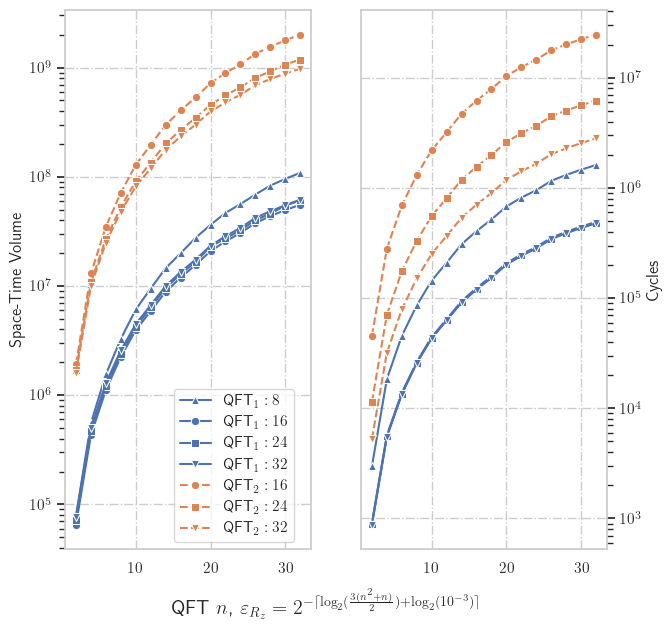

In [18]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#plt.grid(True,which="both")  

qcb_sizes = sizes = [8, 16, 24, 32]
markers = ['^', 'o', 's', 'v']
linestyles = ['-', '--', ':']

res = results_qft
targ_key = 'distillery'

dependent = 'volume'
independent = 'qft'
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 2), (0, 0), colspan=1),
    plt.subplot2grid((1, 2), (0, 1), colspan=1)
]

subplot = ax[0]
kwargs = {
'errorbar':('ci', 100)
}

for idx, target in enumerate((1, 2, 3)):
    for jdx, size in enumerate(qcb_sizes):
        sbs.lineplot(
            ax=subplot,
            **plt_data(
                res,
                independent,
                dependent,
                distillery=target,
                height=size
            ),
            label=f'QFT$_{target}$',
            linestyle=linestyles[idx],
            marker=markers[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )

subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'
subplot = ax[1]

for idx, target in enumerate((1, 2, 3)):
    for jdx, size in enumerate(qcb_sizes):
        sbs.lineplot(
            ax=subplot,
            **plt_data(
                res,
                independent,
                dependent,
                distillery=target,
                height=size
            ),
            label=f'QFT$_{target}: {size}$ ',
            linestyle=linestyles[idx],
            marker=markers[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )


subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

fig = plt.gcf()
fig.set_size_inches(7, 7)

lines = linestyles * 3

handles, labels = subplot.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.27, 0.35))
fig.supxlabel('$n, n \\rightarrow 2n + 1$ Multiplication')


fig.supxlabel('QFT $n$, $\\varepsilon_{R_z} = 2^{{-\\lceil\\log_2(\\frac{{3(n^2 + n)}}{{2}}) + \\log_2(10^{{-3}})\\rceil}}$')

plt.savefig('qft_bank.pdf')

In [17]:
print(results_2)

{'height': [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64], 'distillery': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'volume': [17716925, 28499688, 41689792, 57870436, 81906518, 100847492, 130512807, 154136369, 199603438, 229284780, 240806530, 1370815, 4261511, 8799618, 14674358, 23828239, 33297813, 46312108, 65940777, 79700258, 99331903, 115673154, 148611567, 166789301, 

In [39]:
qcb = qft(10, 16, 16, t_factory=t_factories[1])

Building Cache: 10 / 10                 

In [47]:
qcb.width

176

In [44]:
qcb.dag.physical_externs[0].width

16

In [40]:
len(qcb.dag.physical_externs)

10

In [38]:
len(qcb.dag.physical_externs)

10

In [4]:
import gc
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'qft':[]}
sizes = [16]#, 24, 32]

#toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

min_reg = 29
max_reg = 32

for size in sizes:
    for distillery, extern in zip((2,), t_factories[1:]):
        for i in range(min_reg, max_reg + 1):
            print(f"Compiling:{distillery} {size} {i}" + " " * 15, flush=True, end='\n')
            try:
                qcb = qft(i, size, size, t_factory=extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['qft'].append(i)
                del qcb
                gc.collect()
            except: # This will likely be an allocation size issue
                pass
        
results_qft_5 = results

Compiling:2 16 29               
Building Cache: 29 / 29                 Compiling:2 16 30               
Building Cache: 30 / 30                 Compiling:2 16 31               
Building Cache: 31 / 31                 Compiling:2 16 32               
Building Cache: 32 / 32                 

In [ ]:
import tracemalloc

In [9]:
results_2 = {'height': [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64], 'distillery': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'volume': [17716925, 28499688, 41689792, 57870436, 81906518, 100847492, 130512807, 154136369, 199603438, 229284780, 240806530, 1370815, 4261511, 8799618, 14674358, 23828239, 33297813, 46312108, 65940777, 79700258, 99331903, 115673154, 148611567, 166789301, 174097185, 221996688, 252656526, 285176315, 320128284, 357255097, 399990422, 438133967, 481585136, 528009733, 577003708, 694849859, 753619943, 815020825, 886150664, 945172306, 1015251125, 1357607, 4332104, 8703547, 14651776, 24004527, 34011638, 47474939, 65539042, 78939265, 100620045, 117152455, 148212618, 167914300, 173800208, 223434119, 258621489, 292028625, 330252275, 368299895, 411786741, 440467401, 484487732, 530794716, 579408375, 697778003, 756781353, 818466474, 882773195, 949768215, 1019440053, 1091952280, 1167480252, 1245465314, 1326343514, 1410074417, 1545017962, 1637294730, 1732728277, 1831129097, 1932811710, 2037508748, 2145237987, 2256357897, 2370452878, 2487886046, 2608577665, 2732692133, 2852259766, 2982552107, 3116257461, 3253321471, 3606078210, 3759020637, 3915643111, 4076008873, 4239903528, 4407786787, 4579703869, 4755237471, 4934649062, 5117727599], 'runtime': [401643, 654858, 916800, 1271287, 1760295, 2121663, 2689173, 3111969, 3950159, 4449359, 4584200, 12832, 20235, 40473, 67403, 109833, 153765, 213167, 295095, 355638, 450673, 521799, 662067, 745657, 769023, 983403, 1114931, 1254144, 1401690, 1557433, 1721583, 1893510, 2073844, 2262375, 2459403, 2947103, 3182873, 3427709, 3681613, 3944585, 4216625, 6452, 20235, 40473, 67403, 109833, 153765, 213167, 295095, 355638, 450673, 521799, 662067, 745657, 769023, 983403, 1114795, 1254144, 1401690, 1557433, 1721373, 1893510, 2073844, 2262375, 2459103, 2947103, 3182871, 3427707, 3681611, 3944583, 4216623, 4497731, 4787907, 5087151, 5395463, 5712843, 6233097, 6579380, 6935022, 7300023, 7674383, 8058102, 8451180, 8853617, 9265413, 9686568, 10117082, 10556955, 11016771, 11478253, 11944203, 12421971, 13719371, 14247039, 14784665, 15332245, 15889781, 16457273, 17034721, 17622125, 18219485, 18826801], 'qft': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]}

In [8]:
results_qft = {'height': [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64], 'distillery': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'volume': [167494, 349728, 620681, 915453, 1349392, 1838936, 2591786, 3255677, 4046027, 4737713, 6112348, 6921639, 7515745, 54599, 184449, 388150, 646728, 1095961, 1517106, 2107108, 3143485, 3755166, 4705888, 5485098, 7011615, 7993755, 8462835, 11004288, 12523910, 14210255, 16033170, 18039737, 20109032, 22652054, 24559611, 27191449, 29996008, 35791459, 39078011, 42936547, 46865840, 49656076, 54301190, 63028, 217790, 451983, 784768, 1305151, 1883366, 2651517, 3672862, 4439640, 5731259, 6669451, 8467974, 9629285, 10035545, 12925639, 15353719, 17406149, 19887514, 22256923, 25133439, 26311428, 29057878, 31982676, 35034675, 42113253, 45882099, 49846188, 53869791, 58237020, 62703483, 67405752, 72459996, 77736521, 83058884, 88752737, 98046382, 104282288, 110509562, 117414471, 124162310, 131526824, 138437877, 146511083, 154287346, 161942924, 171110717, 179261051, 188295254, 197481574, 206650128, 216703279, 239241168, 250061270, 261173967, 272598519, 284386730, 296327824, 308662894, 320996301, 333767370, 347689550, 10001166, 17716925, 28499688, 41689792, 57870436, 81906518, 100847492, 130512807, 154136369, 199603438, 229284780, 240806530, 1370815, 4261511, 8799618, 14674358, 23828239, 33297813, 46312108, 65940777, 79700258, 99331903, 115673154, 148611567, 166789301, 174097185, 221996688, 252656526, 285176315, 320128284, 357255097, 399990422, 438133967, 481585136, 528009733, 577003708, 694849859, 753619943, 815020825, 886150664, 945172306, 1015251125, 1357607, 4332104, 8703547, 14651776, 24004527, 34011638, 47474939, 65539042, 78939265, 100620045, 117152455, 148212618, 167914300, 173800208, 223434119, 258621489, 292028625, 330252275, 368299895, 411786741, 440467401, 484487732, 530794716, 579408375, 697778003, 756781353, 818466474, 882773195, 949768215, 1019440053, 1091952280, 1167480252, 1245465314, 1326343514, 1410074417, 1545017962, 1637294730, 1732728277, 1831129097, 1932811710, 2037508748, 2145237987, 2256357897, 2370452878, 2487886046, 2608577665, 2732692133, 2852259766, 2982552107, 3116257461, 3253321471, 3606078210, 3759020637, 3915643111, 4076008873, 4239903528, 4407786787, 4579703869, 4755237471, 4934649062, 5117727599], 'runtime': [3987, 7971, 13253, 13023, 18672, 25455, 35355, 43023, 54673, 62241, 78317, 87365, 90935, 749, 2349, 4839, 7763, 12903, 18189, 24419, 34671, 42078, 52638, 59469, 75585, 85088, 89253, 114123, 129611, 146271, 162795, 182783, 199503, 221301, 240100, 262755, 283503, 334428, 364694, 388211, 418997, 446315, 480350, 743, 2295, 4719, 7773, 12753, 18000, 24363, 34275, 41178, 53243, 58479, 75897, 84542, 87993, 111243, 127299, 143670, 160401, 178413, 196983, 216681, 237317, 259719, 282303, 330528, 358374, 388209, 412905, 445878, 475233, 507411, 536979, 576150, 611068, 651423, 722613, 763461, 798060, 847863, 885603, 935910, 970728, 1028305, 1073163, 1110558, 1177212, 1217115, 1271259, 1326678, 1374453, 1437387, 1558521, 1618464, 1679540, 1740205, 1805081, 1869548, 1933435, 1994795, 2060585, 2138726, 240987, 401643, 654858, 916800, 1271287, 1760295, 2121663, 2689173, 3111969, 3950159, 4449359, 4584200, 12832, 20235, 40473, 67403, 109833, 153765, 213167, 295095, 355638, 450673, 521799, 662067, 745657, 769023, 983403, 1114931, 1254144, 1401690, 1557433, 1721583, 1893510, 2073844, 2262375, 2459403, 2947103, 3182873, 3427709, 3681613, 3944585, 4216625, 6452, 20235, 40473, 67403, 109833, 153765, 213167, 295095, 355638, 450673, 521799, 662067, 745657, 769023, 983403, 1114795, 1254144, 1401690, 1557433, 1721373, 1893510, 2073844, 2262375, 2459103, 2947103, 3182871, 3427707, 3681611, 3944583, 4216623, 4497731, 4787907, 5087151, 5395463, 5712843, 6233097, 6579380, 6935022, 7300023, 7674383, 8058102, 8451180, 8853617, 9265413, 9686568, 10117082, 10556955, 11016771, 11478253, 11944203, 12421971, 13719371, 14247039, 14784665, 15332245, 15889781, 16457273, 17034721, 17622125, 18219485, 18826801], 'qft': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]}

In [19]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#plt.grid(True,which="both")  


markers = ['^', 'o', 's', 'v']
linestyles = ['-', '--', ':']

res = results_approx
targ_key = 'distillery'

dependent = 'volume'
independent = 'qft'
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 2), (0, 0), colspan=1),
    plt.subplot2grid((1, 2), (0, 1), colspan=1)
]

subplot = ax[0]
kwargs = {
'errorbar':('ci', 100)
}

for idx, target in enumerate((1, 2, 3)):
    for jdx, size in enumerate(qcb_sizes):
        sbs.lineplot(
            ax=subplot,
            **plt_data(
                res,
                independent,
                dependent,
                distillery=target,
                height=size
            ),
            label=f'QFT$_{target}$',
            linestyle=linestyles[idx],
            marker=markers[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )

subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'
subplot = ax[1]

for idx, target in enumerate((1, 2, 3)):
    for jdx, size in enumerate(qcb_sizes):
        sbs.lineplot(
            ax=subplot,
            **plt_data(
                res,
                independent,
                dependent,
                distillery=target,
                height=size
            ),
            label=f'QFT$_{target}: {size}$ ',
            linestyle=linestyles[idx],
            marker=markers[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )

 
subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

fig = plt.gcf()
fig.set_size_inches(7, 7)

lines = linestyles * 3

handles, labels = subplot.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.15, 0.94), ncol=3)

fig.supxlabel('QFT $n$, $\\varepsilon_{R_z} = 2^{{-\\lceil\\log_2(\\frac{{3(n^2 + n)}}{{2}}) + \\log_2(10^{{-3}})\\rceil}}$')

#plt.savefig('qft_approx.pdf')

NameError: name 'results_approx' is not defined

In [1]:
results_qft = {'height': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], 'distillery': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'volume': [72468, 243661, 485606, 845152, 1288474, 1916818, 2613165, 3651698, 4679900, 5862326, 7219171, 9405606, 11246895, 13301365, 15593567, 18131939, 20937914, 25306148, 28840110, 32511706, 36327511, 40273264, 44367415, 48592347, 56279204, 63684417, 68913781, 74287524, 79786464, 85463381, 91281238, 64847, 212966, 417954, 707356, 1068625, 1538720, 2063299, 2828403, 3562927, 4390409, 5328310, 6842910, 8048737, 9434232, 10821596, 12512962, 14250364, 17018010, 19126489, 21354566, 23559921, 25877258, 28404589, 30694829, 35178996, 37830958, 40694514, 43579789, 46352081, 49525914, 52322973, 1863597, 6167552, 12102689, 20767880, 31230663, 45862342, 61757921, 85335725, 108157056, 134108185, 163506606, 211152692, 250232734, 293462414, 341198102], 'runtime': [2980, 9606, 18415, 30872, 45386, 65232, 86012, 116311, 144471, 175535, 209832, 265602, 308815, 355418, 405783, 459826, 517764, 610830, 679540, 748383, 817351, 886066, 954967, 1023786, 1161139, 1237015, 1312890, 1388652, 1464612, 1540393, 1616216, 1027, 3315, 6352, 10490, 15474, 22488, 29523, 39965, 49524, 60544, 71994, 90425, 105396, 121078, 138422, 157021, 176442, 208780, 231656, 255294, 278454, 301864, 326358, 350042, 394986, 420857, 447178, 472236, 498159, 523227, 550126, 45408, 146694, 281165, 471507, 693290, 996014, 1312691, 1776023, 2205046, 2679474, 3202799, 4056677, 4716780, 5429272, 6197645], 'qft': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}

In [2]:
results_qft_2 = {'height': [16, 16, 16, 16, 16, 16, 16, 16],
 'distillery': [2, 2, 2, 2, 2, 2, 2, 2],
 'volume': [395194043,
  452926712,
  543455743,
  615098538,
  688837349,
  764690284,
  842638187,
  922700656],
 'runtime': [7023645,
  7909014,
  9327048,
  10378317,
  11429595,
  12480882,
  13532178,
  14583483],
 'qft': [17, 18, 19, 20, 21, 22, 23, 24]}

In [3]:
results_qft_3 = {'height': [16, 16, 16, 16, 16, 16, 16, 16],
 'distillery': [2, 2, 2, 2, 2, 2, 2, 2],
 'volume': [401145760,
  459627396,
  551358762,
  623890280,
  698520820,
  775261114,
  854101276,
  935052992],
 'runtime': [7023282,
  7908609,
  9326553,
  10377771,
  11428998,
  12480234,
  13531479,
  14582733],
 'qft': [17, 18, 19, 20, 21, 22, 23, 24]}

In [4]:
results_qft_4 = {'height': [16, 16, 16, 16],
 'distillery': [2, 2, 2, 2],
 'volume': [1012405984, 1166287029, 1261323735, 1358686309],
 'runtime': [15633996, 17736265, 18894046, 20051836],
 'qft': [25, 26, 27, 28]}

In [5]:
results_qft_5 = {'height': [16, 16, 16, 16],
 'distillery': [2, 2, 2, 2],
 'volume': [1447862495, 1549291355, 1653026251, 1759095891],
 'runtime': [21209635, 22367443, 23525260, 24683086],
 'qft': [29, 30, 31, 32]}

In [6]:
results = {i:[] for i in results_qft.keys()}

In [7]:
for r in (results_qft, results_qft_2, results_qft_3, results_qft_4, results_qft_5):
    for key in results:
        results[key] += r[key]

In [10]:
results_qft = {'height': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], 'distillery': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'volume': [72468, 243661, 485606, 845152, 1288474, 1916818, 2613165, 3651698, 4679900, 5862326, 7219171, 9405606, 11246895, 13301365, 15593567, 18131939, 20937914, 25306148, 28840110, 32511706, 36327511, 40273264, 44367415, 48592347, 56279204, 63684417, 68913781, 74287524, 79786464, 85463381, 91281238, 64847, 212966, 417954, 707356, 1068625, 1538720, 2063299, 2828403, 3562927, 4390409, 5328310, 6842910, 8048737, 9434232, 10821596, 12512962, 14250364, 17018010, 19126489, 21354566, 23559921, 25877258, 28404589, 30694829, 35178996, 37830958, 40694514, 43579789, 46352081, 49525914, 52322973, 1863597, 6167552, 12102689, 20767880, 31230663, 45862342, 61757921, 85335725, 108157056, 134108185, 163506606, 211152692, 250232734, 293462414, 341198102, 395194043, 452926712, 543455743, 615098538, 688837349, 764690284, 842638187, 922700656, 401145760, 459627396, 551358762, 623890280, 698520820, 775261114, 854101276, 935052992, 1012405984, 1166287029, 1261323735, 1358686309, 1447862495, 1549291355, 1653026251, 1759095891], 'runtime': [2980, 9606, 18415, 30872, 45386, 65232, 86012, 116311, 144471, 175535, 209832, 265602, 308815, 355418, 405783, 459826, 517764, 610830, 679540, 748383, 817351, 886066, 954967, 1023786, 1161139, 1237015, 1312890, 1388652, 1464612, 1540393, 1616216, 1027, 3315, 6352, 10490, 15474, 22488, 29523, 39965, 49524, 60544, 71994, 90425, 105396, 121078, 138422, 157021, 176442, 208780, 231656, 255294, 278454, 301864, 326358, 350042, 394986, 420857, 447178, 472236, 498159, 523227, 550126, 45408, 146694, 281165, 471507, 693290, 996014, 1312691, 1776023, 2205046, 2679474, 3202799, 4056677, 4716780, 5429272, 6197645, 7023645, 7909014, 9327048, 10378317, 11429595, 12480882, 13532178, 14583483, 7023282, 7908609, 9326553, 10377771, 11428998, 12480234, 13531479, 14582733, 15633996, 17736265, 18894046, 20051836, 21209635, 22367443, 23525260, 24683086], 'qft': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]}